<a href="https://colab.research.google.com/github/muntasir-islam/ModalX-AI-Challenge/blob/main/Phase_1_Speech_Analysis/modalx_voice_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install librosa numpy pandas matplotlib seaborn scikit-learn tensorflow

In [2]:
from google.colab import files
import os

# 1. Upload kaggle.json
files.upload()

# 2. Setup Kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Download and Unzip TESS Data
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!unzip -q toronto-emotional-speech-set-tess.zip
print("Dataset downloaded and extracted!")

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 96% 412M/428M [00:00<00:00, 458MB/s]
100% 428M/428M [00:00<00:00, 530MB/s]
Dataset downloaded and extracted!


In [3]:
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# Path to the unzipped dataset
DATA_DIR = './TESS Toronto emotional speech set data/'

data = []
labels = []

# Loop through all folders (e.g., "OAF_Fear", "YAF_happy")
for dirname in tqdm(os.listdir(DATA_DIR)):
    if os.path.isdir(os.path.join(DATA_DIR, dirname)):
        # The emotion is usually the last part of the folder name (e.g., "OAF_Fear" -> "Fear")
        emotion = dirname.split('_')[-1].lower()

        # Loop through files in that folder
        folder_path = os.path.join(DATA_DIR, dirname)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)

            # Load audio (librosa loads as mono by default)
            y, sr = librosa.load(file_path, duration=3, offset=0.5)

            # Extract MFCCs (approx. 40 features is standard for human speech)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

            # Take the mean of the MFCCs across time to get a single vector per file
            mfccs_mean = np.mean(mfccs.T, axis=0)

            data.append(mfccs_mean)
            labels.append(emotion)

# Convert to arrays
X = np.array(data)
y = np.array(labels)

print(f"Data Shape: {X.shape}")
print(f"Labels loaded: {np.unique(y)}")

100%|██████████| 14/14 [00:57<00:00,  4.12s/it]

Data Shape: (2800, 40)
Labels loaded: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise' 'surprised']


In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. One Hot Encode Labels
enc = OneHotEncoder()
y_encoded = enc.fit_transform(y.reshape(-1, 1)).toarray()

# 2. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 3. Reshape for CNN
# CNN expects input shape: (batch, steps, channels) -> (batch, 40, 1)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(f"Training shape: {X_train.shape}")

Training shape: (2240, 40, 1)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

model = Sequential([
    # Layer 1
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(40, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Layer 2
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Flatten and Dense
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3), # Prevents overfitting
    Dense(7, activation='softmax') # 7 output neurons for 7 emotions
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 38, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,927 (1.11 MB)

 Trainable params: 289,543 (1.10 MB)

 Non-trainable params: 384 (1.50 KB)

In [7]:
# 1. Get the actual number of classes found in the data
num_classes = y_encoded.shape[1]
print(f"Detected {num_classes} categories: {enc.categories_[0]}")

# 2. Re-build the model with the correct output size
model = Sequential([
    # Layer 1
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(40, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Layer 2
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Flatten and Dense
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),

    # --- FIX IS HERE: Use 'num_classes' instead of 7 ---
    Dense(num_classes, activation='softmax')
])

# 3. Re-compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Train again
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Detected 8 categories: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise' 'surprised']
Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7610 - loss: 0.7067 - val_accuracy: 0.8161 - val_loss: 0.5246
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9864 - loss: 0.0388 - val_accuracy: 0.9250 - val_loss: 0.2087
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9939 - loss: 0.0223 - val_accuracy: 0.9821 - val_loss: 0.0570
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9903 - loss: 0.0234 - val_accuracy: 0.9893 - val_loss: 0.0338
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9876 - loss: 0.0395 - val_accuracy: 0.9911 - val_loss: 0.0251
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9930 - loss: 0.0165 - val_accuracy: 0.9911 - val_loss: 0.0320
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9968 - loss: 0.0067 - val_accuracy: 0.9857 - val_loss: 0.0402
Epoch 8/50
70/

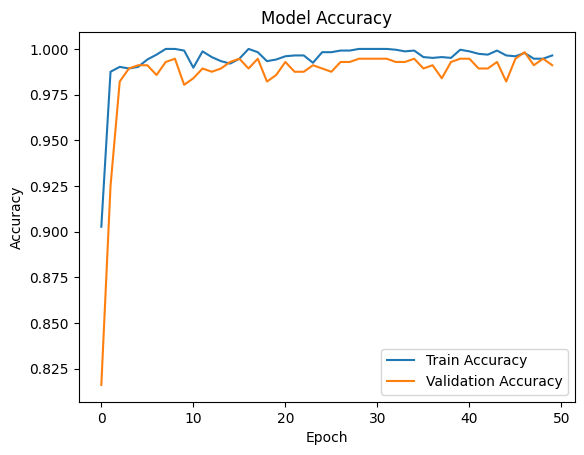

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


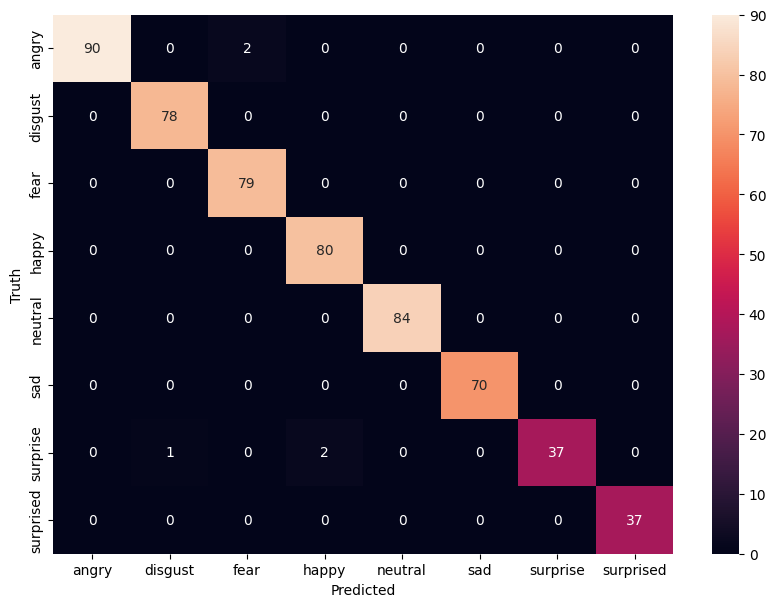

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Predict on Test Set
pred_test = model.predict(X_test)
y_pred = enc.inverse_transform(pred_test)
y_true = enc.inverse_transform(y_test)

# Show a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [9]:
# Save the model architecture and weights
model.save('modalx_emotion_model.h5')
print("Model saved successfully as 'modalx_emotion_model.h5'")

# Optional: Download it to your local computer
from google.colab import files
files.download('modalx_emotion_model.h5')

Model saved successfully as 'modalx_emotion_model.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import librosa
import numpy as np

def predict_emotion(audio_path):
    # 1. Load the audio file
    # We use the same duration (3s) as training to keep shapes consistent
    y, sr = librosa.load(audio_path, duration=3, offset=0.5)

    # 2. Extract features (MFCC) exactly like we did in training
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    # 3. Reshape for the model (Batch, Steps, Channels)
    # The model expects shape (1, 40, 1)
    input_data = np.expand_dims(mfccs_mean, axis=0) # Add batch dimension
    input_data = np.expand_dims(input_data, axis=2) # Add channel dimension

    # 4. Predict
    prediction = model.predict(input_data, verbose=0)

    # 5. Decode the result
    predicted_index = np.argmax(prediction)
    predicted_label = enc.categories_[0][predicted_index]

    return predicted_label, prediction[0]

# --- TEST IT ---
# Replace 'test_audio.wav' with a path to a real file you upload
# For now, let's test it on one of the files from the dataset itself to verify
import random

test_folder = random.choice(os.listdir(DATA_DIR))
test_file = random.choice(os.listdir(os.path.join(DATA_DIR, test_folder)))
full_path = os.path.join(DATA_DIR, test_folder, test_file)

print(f"Testing on file: {test_file}")
print(f"True Label: {test_folder}")
emotion, confidence = predict_emotion(full_path)
print(f"Predicted: {emotion.upper()}")

Testing on file: YAF_should_happy.wav
True Label: YAF_happy
Predicted: HAPPY
